# Train Pitch Type Prediction Model

Starting with the most simplicistic prediction, the goal with this experiment is to predict whether a pitcher will pitch a ball or a strike, given a basic game scenario.

Ideas for getting better accuracy:
- Filter data based on pitcher (and catcher?).  Do not think this will work because of model training aspect - not transactional.
- Is the game packed or is it empty?
- Is it at night?
- Is it cold?
- Is it raining?

In [1]:
try:
    if metrics_output is not None:
        print ("KFP metric output was found.  Will log output metrics at the end of the process")
    else:
        print ("KFP metric output not found.")
except NameError:
    print ("KFP metric output not found.")
    metrics_output = None

KFP metric output not found.


In [2]:
import os
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from train_tools import SCALER_SUFFIX

from train_tools import acquire_data, drop_column
from train_tools import scale_int_values, extract_categorical_columns
from train_tools import replace_populated_values_with_tf_num, replace_boolean_values_with_tf_num
from train_tools import model_train, save_model, evaluate_model

In [3]:
output_dir = "../../../target/models/predict_pitch/"
onnx_path = os.path.join(output_dir, "model.onnx")
roc_path = os.path.join(output_dir, "roc.jpg")
dataset_size = 5000
db_conn_str = "postgresql://baseball_app:baseball123@db/baseball_db"
neural_network_width = 10


In [4]:
output_dir = os.path.abspath(output_dir)
print ("Output Directory: " + output_dir)

# ensure the model directory exists
if not os.path.exists(output_dir):
    print ("Creating output directory: " + output_dir)
    os.makedirs(output_dir)

Output Directory: /Users/lroland/Projects/github.com/baseball/target/models/predict_pitch


## Acquire Data

Pull relevant attributes from the baseball database as a DataFrame for analysis and training.

In [5]:
if dataset_size is not None and isinstance(dataset_size, str) and len(dataset_size) > 0:
    dataset_size = int(dataset_size)
print ("Data Set Size: " + str(dataset_size))

Data Set Size: 5000


In [6]:
sql = """
        select random() as r_id, game_play_atbat.player_code as player_code, pitch_index, pitch_type.pitch_type_cd as pitch_type_cd, home_team_flag, game_play_atbat.score_home as score_home, game_play_atbat.score_visitor as score_visitor, sky, night_flag, temperature, wind_direction, wind_speed, precipitation, field_condition, roster_batter.batting_hand as batting_hand, roster_pitcher.throw_hand as pitching_hand, runner_1b, runner_2b, runner_3b, ball_or_strike, pitch_count
        from game, game_play, game_play_atbat, game_play_atbat_pitch, roster as roster_batter, roster as roster_pitcher, pitch_type
        where game.game_id = game_play.game_id
        and game_play_atbat.game_play_id = game_play.game_play_id
        and game_play_atbat_pitch.game_play_id = game_play.game_play_id
        and roster_batter.player_code = game_play_atbat.player_code
        and roster_batter.season_year = date_part('year', game.game_date)
        and roster_pitcher.player_code = game_play_atbat.pitcher
        and roster_pitcher.season_year = roster_batter.season_year
        and pitch_type.pitch_type_cd = game_play_atbat_pitch.pitch_type_cd
        and pitch_type.ball_or_strike is not null
        order by r_id  
      """

full_df = acquire_data(db_conn_str, sql, dataset_size)

full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   r_id             5000 non-null   float64
 1   player_code      5000 non-null   object 
 2   pitch_index      5000 non-null   int64  
 3   pitch_type_cd    5000 non-null   object 
 4   home_team_flag   5000 non-null   bool   
 5   score_home       5000 non-null   int64  
 6   score_visitor    5000 non-null   int64  
 7   sky              5000 non-null   object 
 8   night_flag       5000 non-null   bool   
 9   temperature      5000 non-null   int64  
 10  wind_direction   5000 non-null   object 
 11  wind_speed       5000 non-null   int64  
 12  precipitation    5000 non-null   object 
 13  field_condition  5000 non-null   object 
 14  batting_hand     5000 non-null   object 
 15  pitching_hand    5000 non-null   object 
 16  runner_1b        1979 non-null   object 
 17  runner_2b     

In [7]:
def calculate_score_deficit(row):
    is_home = row["home_team_flag"]
    score_home = row["score_home"]
    score_visitor = row["score_visitor"]

    if is_home:
        return score_home - score_visitor
    else:
        return score_visitor - score_home

full_df['score_deficit'] = full_df.apply(lambda x: calculate_score_deficit(x), axis=1)

In [8]:
full_df.head()

,r_id,player_code,pitch_index,pitch_type_cd,home_team_flag,score_home,score_visitor,sky,night_flag,temperature,...,precipitation,field_condition,batting_hand,pitching_hand,runner_1b,runner_2b,runner_3b,ball_or_strike,pitch_count,score_deficit
0,3.553349e-08,pagaa001,1,F,True,1,1,dome,False,72,...,none,dry,R,R,pagaa001,None,duffm002,S,69,0
1,1.624358e-07,mcnej002,3,F,True,9,6,cloudy,True,86,...,unknown,unknown,R,R,None,None,None,S,82,3
2,2.094397e-07,scutm001,2,C,True,1,4,cloudy,True,84,...,unknown,unknown,R,R,scutm001,None,None,S,72,-3
3,3.010024e-07,bogat001,2,C,False,3,0,dome,True,72,...,none,dry,R,R,None,None,None,S,24,-3
4,4.858235e-07,randj002,8,X,False,2,1,sunny,False,90,...,unknown,unknown,R,R,None,randj002,None,S,26,-1


## Prepare Data for Model Training

Prepare data for classification.

In [9]:
# focus data frame on prediction values
df = full_df[["pitch_index", "runner_1b", "runner_2b", "runner_3b", "home_team_flag", "score_deficit", 
              "night_flag", "pitch_count", "ball_or_strike"]]
df = df[df['ball_or_strike'].notnull()]

df = df.convert_dtypes()
df.head()

,pitch_index,runner_1b,runner_2b,runner_3b,home_team_flag,score_deficit,night_flag,pitch_count,ball_or_strike
0,1,pagaa001,<NA>,duffm002,True,0,False,69,S
1,3,<NA>,<NA>,<NA>,True,3,True,82,S
2,2,scutm001,<NA>,<NA>,True,-3,True,72,S
3,2,<NA>,<NA>,<NA>,False,-3,True,24,S
4,8,<NA>,randj002,<NA>,False,-1,False,26,S


In [10]:
replace_populated_values_with_tf_num(df, 'runner_1b', 'is_runner_1b', True)
replace_populated_values_with_tf_num(df, 'runner_2b', 'is_runner_2b', True)
replace_populated_values_with_tf_num(df, 'runner_3b', 'is_runner_3b', True)

replace_boolean_values_with_tf_num(df, "home_team_flag", 'is_home', True)
replace_boolean_values_with_tf_num(df, "night_flag", 'is_night', True)

scale_int_values(df, 'score_deficit', 'score_deficit_scaled', True, 
                 output_dir + "/" + "score_deficit" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_count', 'pitch_count', False,
                 output_dir + "/" + "pitch_count" + SCALER_SUFFIX)
scale_int_values(df, 'pitch_index', 'pitch_index', False,
                 output_dir + "/" + "pitch_index" + SCALER_SUFFIX)

df.head()


,pitch_index,pitch_count,ball_or_strike,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled
0,-1.091370,-0.109557,S,1,0,1,1,0,0.016513
1,-0.078498,0.172403,S,0,0,0,1,1,0.927167
2,-0.584934,-0.044489,S,1,0,0,1,1,-0.894141
3,-0.584934,-1.085572,S,0,0,0,0,1,-0.894141
4,2.453684,-1.042194,S,0,1,0,0,0,-0.287038


In [11]:
df = extract_categorical_columns(df, ["ball_or_strike"])
drop_column(df, "ball_or_strike_B")
df.rename(columns={'ball_or_strike_S': 'is_strike'}, inplace=True)

df.head()

,pitch_index,pitch_count,is_runner_1b,is_runner_2b,is_runner_3b,is_home,is_night,score_deficit_scaled,is_strike
0,-1.091370,-0.109557,1,0,1,1,0,0.016513,True
1,-0.078498,0.172403,0,0,0,1,1,0.927167,True
2,-0.584934,-0.044489,1,0,0,1,1,-0.894141,True
3,-0.584934,-1.085572,0,0,0,0,1,-0.894141,True
4,2.453684,-1.042194,0,1,0,0,0,-0.287038,True


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pitch_index           5000 non-null   float64
 1   pitch_count           5000 non-null   float64
 2   is_runner_1b          5000 non-null   int64  
 3   is_runner_2b          5000 non-null   int64  
 4   is_runner_3b          5000 non-null   int64  
 5   is_home               5000 non-null   int64  
 6   is_night              5000 non-null   int64  
 7   score_deficit_scaled  5000 non-null   float64
 8   is_strike             5000 non-null   boolean
dtypes: boolean(1), float64(3), int64(5)
memory usage: 322.4 KB


In [13]:
df["is_strike"].describe()

count     5000
unique       2
top       True
freq      3151
Name: is_strike, dtype: object

## Train Model

Train a classification model using the prepared data set.

In [14]:
num_features = df.shape[1] - 1
print(f"Number of Features: {num_features}")

print("Columns and their respective order for inferences:")
df.columns[0:num_features]

Number of Features: 8
Columns and their respective order for inferences:


Index(['pitch_index', 'pitch_count', 'is_runner_1b', 'is_runner_2b',
       'is_runner_3b', 'is_home', 'is_night', 'score_deficit_scaled'],
      dtype='object')

In [15]:
# Extract data
X = df.iloc[:, 0:num_features]
y = df.iloc[:, num_features:]

# Convert to 2D PyTorch tensors
Xt = torch.tensor(X.values, dtype=torch.float32)
yt = torch.tensor(y.values, dtype=torch.float32)

In [16]:
class PitchPredictionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(num_features, num_features*neural_network_width)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(num_features*neural_network_width, num_features*neural_network_width)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(num_features*neural_network_width, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

In [17]:
X_train, X_test, y_train, y_test = train_test_split(Xt, yt, train_size=0.7, shuffle=True)

print ("Training Shapes: ")
print ()
print ("X_train = " + str(list(X_train.size())))
print ("y_train = " + str(list(y_train.size())))
print ("X_test = " + str(list(X_test.size())))
print ("y_test = " + str(list(y_test.size())))

Training Shapes: 

X_train = [3500, 8]
y_train = [3500, 1]
X_test = [1500, 8]
y_test = [1500, 1]


In [18]:
model = PitchPredictionModel()
final_acc = model_train(model, X_train, y_train, X_test, y_test)

print(f"Final model accuracy: {final_acc*100:.2f}%")

Epoch 49: 100%|██████████| 350/350 [00:00<00:00, 437.09batch/s, acc=0.6, loss=0.577]


Final model accuracy: 62.20%


ROC Image Output Filename: /Users/lroland/Projects/github.com/baseball/target/models/predict_pitch/roc.jpg
[-1.0913701 -0.326449   1.         0.         0.         0.
  1.         0.0165132] -> [0.592573] (expected [0.])
[ 0.4279386 -1.3892214  0.         1.         0.         1.
  1.         0.0165132] -> [0.7338681] (expected [1.])
[-0.07849762  0.7363235   0.          0.          0.          0.
  1.          0.0165132 ] -> [0.6509804] (expected [1.])
[ 0.93437487  0.02057875  0.          0.          0.          0.
  1.         -0.59058964] -> [0.74306893] (expected [1.])
[-0.07849762  0.77970195  0.          0.          0.          1.
  1.         -0.28703824] -> [0.66266763] (expected [1.])


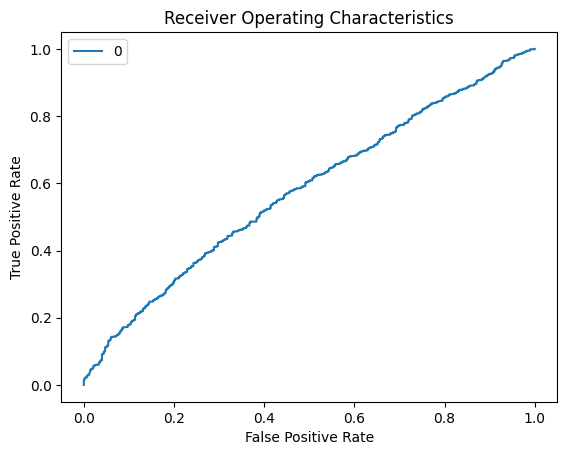

KFP not detected.  Skipping metrics logging.
{'__name__': 'train_tools', '__doc__': ' Utility methods for use by prediction services. ', '__package__': '', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x110cef6d0>, '__spec__': ModuleSpec(name='train_tools', loader=<_frozen_importlib_external.SourceFileLoader object at 0x110cef6d0>, origin='/Users/lroland/Projects/github.com/baseball/data/src/train/train_tools.py'), '__file__': '/Users/lroland/Projects/github.com/baseball/data/src/train/train_tools.py', '__cached__': '/Users/lroland/Projects/github.com/baseball/data/src/train/__pycache__/train_tools.cpython-311.pyc', '__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, types, exceptions, and other objects.\n\nThis module provides direct access to all 'built-in'\nidentifiers of Python; for example, builtins.len is\nthe full name for the built-in function len().\n\nThis module is not normally accessed explicitly by most\napplications, but can be

In [19]:
roc_path = os.path.abspath(roc_path)
print("ROC Image Output Filename: " + roc_path)

evaluate_model(model, X_test, y_test, roc_path, metrics_output=metrics_output)

## Save the model

Save the model to disk for use by an inference service.

In [20]:
onnx_path = os.path.abspath(onnx_path)
print ("ONNX Model Output Filename: " + onnx_path)

save_model(model, num_features, onnx_path)

ONNX Model Output Filename: /Users/lroland/Projects/github.com/baseball/target/models/predict_pitch/model.onnx
